# Modélisation des crises économiques

In [1]:
# Data Processing and Visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter
from tools import *  # Ensure that functions like plot_time_series, impute_nan_values_time_series, align_date_ranges are defined here
from scipy.signal import find_peaks

# PCA
from sklearn.decomposition import PCA

# Modeling and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    roc_auc_score, recall_score, balanced_accuracy_score, roc_curve, auc,
    precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler



## Import Data

In [2]:
cycles_processed = pd.read_csv('./data/cycles_processed.csv')
determinants_processed = pd.read_csv('./data/determinants_processed.csv')

In [3]:
determinants_processed.head()

,year,country,ka_open,cblackmarketexchangerates,acreditmarketregulation,BankAssets_CBShare,FD,Portfolioequityassets,Currentaccountbalance,Capitalaccount,cbie_index,GDPconstant2015US
0,1980,Argentina,0.417237,9.80,4.446113,88.77,0.228351,50.0,-4774.0,0.0,0.5175,2.878000e+11
1,1981,Argentina,0.417237,8.24,4.397397,85.50,0.230102,52.0,-4712.0,0.0,0.5175,2.729000e+11
2,1982,Argentina,0.162948,6.68,4.348682,86.43,0.267035,59.0,-2353.0,0.0,0.5175,2.709000e+11
3,1983,Argentina,0.162948,5.12,4.299967,68.78,0.217450,75.0,-2436.0,0.0,0.5175,2.827000e+11
4,1984,Argentina,0.162948,3.56,4.251251,74.45,0.230107,78.0,-2495.0,0.0,0.5175,2.871000e+11


In [4]:
determinants_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       1831 non-null   int64  
 1   country                    1831 non-null   object 
 2   ka_open                    1831 non-null   float64
 3   cblackmarketexchangerates  1831 non-null   float64
 4   acreditmarketregulation    1831 non-null   float64
 5   BankAssets_CBShare         1831 non-null   float64
 6   FD                         1831 non-null   float64
 7   Portfolioequityassets      1831 non-null   float64
 8   Currentaccountbalance      1831 non-null   float64
 9   Capitalaccount             1831 non-null   float64
 10  cbie_index                 1831 non-null   float64
 11  GDPconstant2015US          1831 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 171.8+ KB


In [5]:
cycles_processed.head()

,year,country,rpp_value,cgdp_value,cr_value,spr_value,rpp_value_trend,rpp_value_cycle,rpp_value_cycle_normalized,cgdp_value_trend,...,cgdp_value_cycle_normalized,cr_value_trend,cr_value_cycle,cr_value_cycle_normalized,spr_value_trend,spr_value_cycle,spr_value_cycle_normalized,pca_weighted_mean,turning_point,value
0,1970,Australia,32.4367,62.4,9.763825,66.374039,17.341553,15.095147,1.000000,56.486108,...,1.000000,-10.215356,19.979181,1.000000,34.124205,32.249834,1.000000,1.000000,NaN,0.0
1,1971,Australia,34.1111,61.8,10.055262,61.761449,19.203306,14.907794,0.987589,59.299733,...,0.422779,-7.646934,17.702196,0.886032,35.588990,26.172459,0.811553,0.896601,NaN,0.0
2,1972,Australia,36.7062,62.7,10.501544,73.306428,21.065096,15.641104,1.036168,62.113373,...,0.099195,-5.078462,15.580006,0.779812,37.053855,36.252573,1.124117,0.885048,NaN,0.0
3,1973,Australia,41.0876,67.2,12.216656,52.346214,22.926999,18.160601,1.203075,64.927049,...,0.384341,-2.509845,14.726501,0.737092,38.518947,13.827267,0.428755,1.056407,NaN,0.0
4,1974,Australia,40.1630,72.4,13.607510,30.332724,24.789129,15.373871,1.018465,67.740783,...,0.787843,0.059049,13.548461,0.678129,39.984503,-9.651779,-0.299281,0.961808,NaN,0.0


In [6]:
cycles_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         1207 non-null   int64  
 1   country                      1207 non-null   object 
 2   rpp_value                    1207 non-null   float64
 3   cgdp_value                   1207 non-null   float64
 4   cr_value                     1207 non-null   float64
 5   spr_value                    1207 non-null   float64
 6   rpp_value_trend              1207 non-null   float64
 7   rpp_value_cycle              1207 non-null   float64
 8   rpp_value_cycle_normalized   1207 non-null   float64
 9   cgdp_value_trend             1207 non-null   float64
 10  cgdp_value_cycle             1207 non-null   float64
 11  cgdp_value_cycle_normalized  1207 non-null   float64
 12  cr_value_trend               1207 non-null   float64
 13  cr_value_cycle    

In [7]:
cycles_processed['turning_point'] = cycles_processed['turning_point'].fillna('')

In [8]:
cycles_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         1207 non-null   int64  
 1   country                      1207 non-null   object 
 2   rpp_value                    1207 non-null   float64
 3   cgdp_value                   1207 non-null   float64
 4   cr_value                     1207 non-null   float64
 5   spr_value                    1207 non-null   float64
 6   rpp_value_trend              1207 non-null   float64
 7   rpp_value_cycle              1207 non-null   float64
 8   rpp_value_cycle_normalized   1207 non-null   float64
 9   cgdp_value_trend             1207 non-null   float64
 10  cgdp_value_cycle             1207 non-null   float64
 11  cgdp_value_cycle_normalized  1207 non-null   float64
 12  cr_value_trend               1207 non-null   float64
 13  cr_value_cycle    

In [9]:
# Merge df
df_crises = pd.merge(determinants_processed, cycles_processed[['pca_weighted_mean', 'year', 'country', 'turning_point', 'value']], on=['year', 'country'], how='inner')
df_crises.head()

,year,country,ka_open,cblackmarketexchangerates,acreditmarketregulation,BankAssets_CBShare,FD,Portfolioequityassets,Currentaccountbalance,Capitalaccount,cbie_index,GDPconstant2015US,pca_weighted_mean,turning_point,value
0,1980,Australia,0.417237,9.80,8.379046,88.67,0.282372,260.00000,-4447.4908,-140.98176,0.391,4.513000e+11,0.017423,,0.000000
1,1981,Australia,0.417237,9.84,8.436436,88.18,0.291066,246.47632,-8580.7468,-158.88845,0.391,4.664000e+11,-0.051863,,0.000000
2,1982,Australia,0.417237,9.88,8.493827,94.03,0.282234,568.27662,-8511.9286,-178.80629,0.391,4.819000e+11,-0.354190,,0.000000
3,1983,Australia,0.417237,9.92,8.551218,95.09,0.319150,953.64589,-6330.4286,-171.65049,0.391,4.712000e+11,-0.404077,,0.000000
4,1984,Australia,0.477069,9.96,8.608609,93.66,0.354872,1245.10990,-8859.5669,-183.43452,0.391,4.928000e+11,-0.413856,trough,-0.413856


In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Création d'une variable cible : 1 si turning_point est 'trough' (crise), 0 sinon
df_crises['is_crisis'] = df_crises['turning_point'].apply(lambda x: 1 if x == 'trough' else 0)
df_crises.head()
# Suppression des colonnes inutiles

df_crises = df_crises.drop(columns=['value', 'pca_weighted_mean','GDPconstant2015US','turning_point', 'country'])

# Vérification des valeurs manquantes
if df_crises.isnull().sum().any():
    df_crises = df_crises.fillna(df_crises.mean())

# Séparation des variables explicatives (X) et de la cible (y)
X = df_crises.drop(columns=['is_crisis'])
y = df_crises['is_crisis']

# Standardisation des données
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Étape 2 : Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
df_crises.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       858 non-null    int64  
 1   ka_open                    858 non-null    float64
 2   cblackmarketexchangerates  858 non-null    float64
 3   acreditmarketregulation    858 non-null    float64
 4   BankAssets_CBShare         858 non-null    float64
 5   FD                         858 non-null    float64
 6   Portfolioequityassets      858 non-null    float64
 7   Currentaccountbalance      858 non-null    float64
 8   Capitalaccount             858 non-null    float64
 9   cbie_index                 858 non-null    float64
 10  is_crisis                  858 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 73.9 KB


## Model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params (Logistic Regression (scaled)): {'logreg__C': 0.001, 'logreg__penalty': 'l2'}
Best CV roc_auc Score: 0.552

Class ordering: [0 1]
Logistic Regression (scaled) Train AUC: 0.610
Logistic Regression (scaled) Train Balanced Acc: 0.590
Logistic Regression (scaled) Train Recall: 0.690
Logistic Regression (scaled) Test AUC: 0.322
Logistic Regression (scaled) Test Balanced Acc: 0.391
Logistic Regression (scaled) Test Recall: 0.273



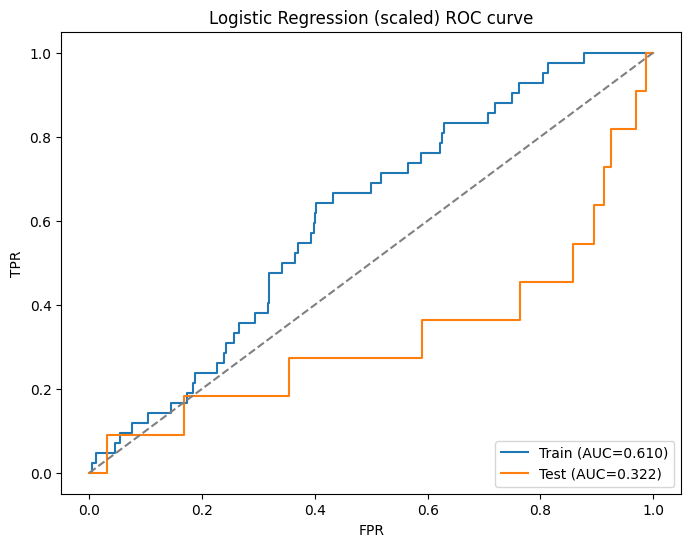

Metrics with Custom Threshold (0.5):
Recall: 0.273
Precision: 0.037
F1 Score: 0.065
ROC AUC: 0.322



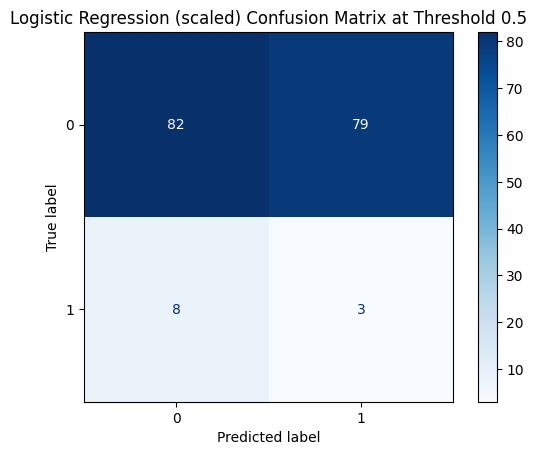

Default Predictions: [1 1 1 1 1 1 0 0 0 1]
Custom Threshold Predictions: [1 1 1 1 1 1 0 0 0 1]
Are they identical? True


In [12]:
pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))
])

param_grid_log = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10],
    "logreg__penalty": ["l2", "l1"],
}

best_log = train_test_with_cv(
    model=pipe_log,
    param_grid=param_grid_log,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression (scaled)",
    scoring="roc_auc",
    threshold=0.5
    
)

Fitting 5 folds for each of 468 candidates, totalling 2340 fits
Best params (Random Forest): {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 35}
Best CV recall Score: 0.219

Class ordering: [0 1]
Random Forest Train AUC: 0.828
Random Forest Train Balanced Acc: 0.733
Random Forest Train Recall: 0.786
Random Forest Test AUC: 0.255
Random Forest Test Balanced Acc: 0.387
Random Forest Test Recall: 0.091



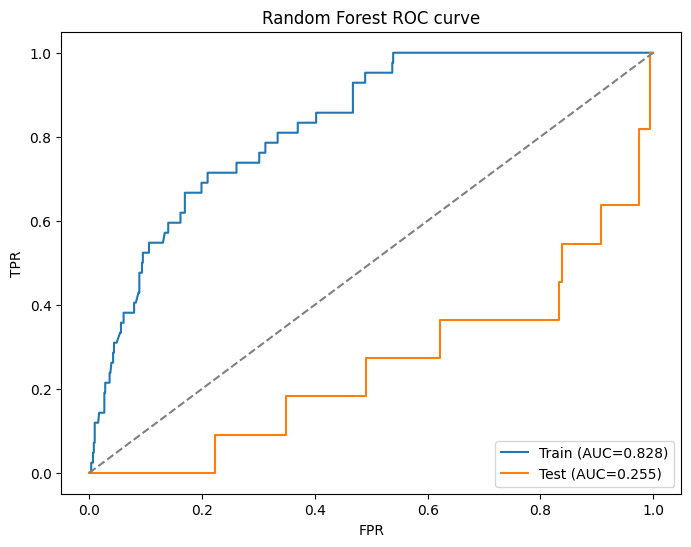

Metrics with Custom Threshold (0.5):
Recall: 0.091
Precision: 0.019
F1 Score: 0.032
ROC AUC: 0.255



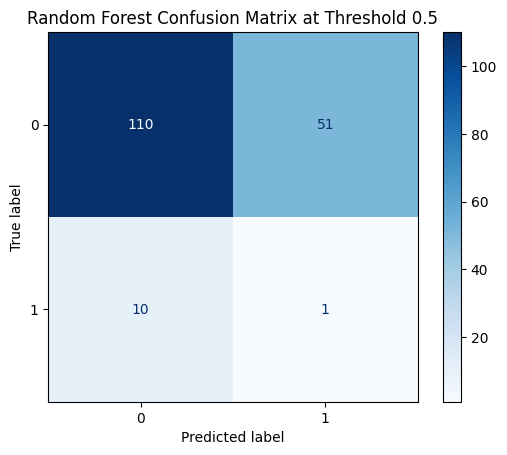

Default and Custom threshold predictions may differ based on threshold logic.


In [13]:
# Définir le modèle
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Définir la grille d'hyperparamètres
param_grid_rf = {
    'n_estimators': range(15, 140,10),  # Nombre d'arbres
    'max_depth': range(3,10,2),       # Profondeur maximale
    'min_samples_split': range(2,8,2), # Min. échantillons pour division
    'min_samples_leaf': range(2,8,2),   # Min. échantillons dans une feuille
    'bootstrap': [True]       # Échantillonnage bootstrap
}

# Appeler la fonction
best_rf = train_test_with_cv(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model=rf_clf,
    param_grid=param_grid_rf,
    model_name="Random Forest",
    scoring='recall',
    threshold=0.5
)




Neither of these models is adapted for the time-series data. The problem requires a specific model which would take the time into the account.